# Import necessary libraries

In [ ]:
import wfdb
import numpy as np
import glob
from scipy import signal, io
from sklearn.decomposition import PCA
from matplotlib import pyplot as plt
from IPython.display import set_matplotlib_formats as set_fmt

# Set matplotlib to use SVG format for clearer plotting in notebooks
set_fmt('svg')         
import warnings  
warnings.filterwarnings("ignore", category=DeprecationWarning)



# reading data

In [ ]:
# Get list of ECG files from the specified directory
listNames = glob.glob('/Users/parisa/Desktop/ECG/mit-bih-arrhythmia-database/*.dat')

# Check if files are found
if not listNames:
    print("No ECG files found in the specified directory.")
else:
    print(f"Processing {len(listNames)} files.")

# filtering

In [ ]:
# Define sampling frequency and filter cutoff frequencies
fs = 360     # Sampling frequency in Hz
fl = 0.5     # Low cutoff frequency for high-pass filter
fh = 20      # High cutoff frequency for low-pass filter

# Create high-pass and low-pass Butterworth filters
b1, a1 = signal.butter(N=3, Wn=fl/(fs/2), btype='high')
b2, a2 = signal.butter(N=3, Wn=fh/(fs/2), btype='low')


In [ ]:
# Define label categories for ECG signal types
table = {'N': ['N'],
         'S': ['A', 'a', 'S', 'J'],
         'F': ['F'],
         'V': ['V'],
         'U': ['Q', 'U', '/', 'p']}


# Segmentation 

In [23]:
# Initialize lists to store segmented ECG data for each type
data0 = []
data1 = []
data2 = []
data3 = []
data4 = []

# Loop through each ECG file
for name in listNames:
     # Extract the record name (without extension)
     parts = name.partition('.')
     recordName = parts[0]
     print(recordName)

     # Read ECG signal and metadata fields
     sig, fields = wfdb.rdsamp(record_name=recordName)
     
     # Apply high-pass and low-pass filters to the ECG signal
     sig = signal.filtfilt(b1, a1, sig[:, 0], padtype='even', axis=0)
     sig = signal.filtfilt(b2, a2, sig, padtype='even')
     
     # Load annotations (R-peak positions and labels)
     annotations = wfdb.rdann(recordName, 'atr')
     pos = annotations.sample
     label = annotations.symbol
     fs = fields['fs']  # Get sampling frequency from metadata

     # Segment ECG signal around each R-peak
     for i in range(1, len(pos) - 1):
          indx = list(range(pos[i] - 80, pos[i] + 120))  # Index range around R-peak
          qrs = sig[indx]
          type = label[i]

          # Classify and store the segmented QRS complex based on the label
          if type in table['N']:
               data0.append(qrs)
          elif type in table['S']:
               data1.append(qrs)
          elif type in table['F']:
               data2.append(qrs)
          elif type in table['V']:
               data3.append(qrs)
          elif type in table['U']:
               data4.append(qrs)  

# Convert lists to numpy arrays for further processing
data0 = np.array(data0, dtype=np.float64)
data1 = np.array(data1, dtype=np.float64)
data2 = np.array(data2, dtype=np.float64)
data3 = np.array(data3, dtype=np.float64)
data4 = np.array(data4, dtype=np.float64)

print('Segmentation is done!')    

/Users/parisa/Desktop/ECG/mit-bih-arrhythmia-database/213
/Users/parisa/Desktop/ECG/mit-bih-arrhythmia-database/207
/Users/parisa/Desktop/ECG/mit-bih-arrhythmia-database/212
/Users/parisa/Desktop/ECG/mit-bih-arrhythmia-database/210
/Users/parisa/Desktop/ECG/mit-bih-arrhythmia-database/205
/Users/parisa/Desktop/ECG/mit-bih-arrhythmia-database/201
/Users/parisa/Desktop/ECG/mit-bih-arrhythmia-database/215
/Users/parisa/Desktop/ECG/mit-bih-arrhythmia-database/214
/Users/parisa/Desktop/ECG/mit-bih-arrhythmia-database/200
/Users/parisa/Desktop/ECG/mit-bih-arrhythmia-database/228
/Users/parisa/Desktop/ECG/mit-bih-arrhythmia-database/202
/Users/parisa/Desktop/ECG/mit-bih-arrhythmia-database/203
/Users/parisa/Desktop/ECG/mit-bih-arrhythmia-database/217
/Users/parisa/Desktop/ECG/mit-bih-arrhythmia-database/106
/Users/parisa/Desktop/ECG/mit-bih-arrhythmia-database/112
/Users/parisa/Desktop/ECG/mit-bih-arrhythmia-database/113
/Users/parisa/Desktop/ECG/mit-bih-arrhythmia-database/107
/Users/parisa/

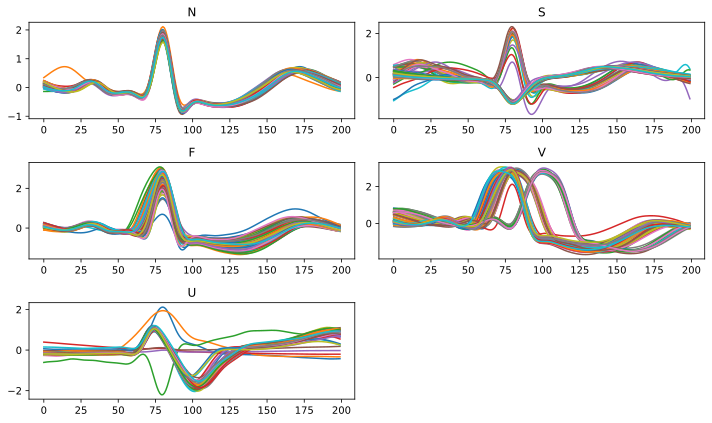

In [26]:
# Plot the first 100 samples of each data class
plt.figure(figsize=(10,6))

plt.subplot(3, 2, 1)
plt.plot(data0[:100, :].T)
plt.title('N')

plt.subplot(3, 2, 2)
plt.plot(data1[:100, :].T)
plt.title('S')

plt.subplot(3, 2, 3)
plt.plot(data2[:100, :].T)
plt.title('F')

plt.subplot(3, 2, 4)
plt.plot(data3[:100, :].T)
plt.title('V')

plt.subplot(3, 2, 5)
plt.plot(data4[:100, :].T)
plt.title('U')

plt.tight_layout()
plt.show()

In [27]:
# Print the shapes of each segmented data array
print(data0.shape)
print(data1.shape)
print(data2.shape)
print(data3.shape)
print(data4.shape)

(75016, 200)
(2779, 200)
(803, 200)
(7130, 200)
(7057, 200)


In [28]:
# Limit each class data to 800 samples (for balanced dataset)
data0 = data0[:800, :]
data1 = data1[:800, :]
data2 = data2[:800, :]
data3 = data3[:800, :]
data4 = data4[:800, :]

In [29]:
# Print the shapes of each dataset after limiting to 800 samples
print(data0.shape)
print(data1.shape)
print(data2.shape)
print(data3.shape)
print(data4.shape)


(800, 200)
(800, 200)
(800, 200)
(800, 200)
(800, 200)


In [30]:
# Organize the data into a dictionary for easier access
ds = {'N': data0,
      'S': data1,
      'F': data2,
      'V': data3,
      'U': data4}

# Concatenate data across all classes to form a single dataset
data = np.concatenate((data0, data1, data2, data3, data4), axis=0)

# Applying PCA 

In [32]:
# Apply PCA to reduce dimensionality of the data
pca = PCA(n_components=60)
pca.fit(data)

PCA(n_components=60)

In [33]:
# Transform each class dataset with the fitted PCA
feature0 = pca.transform(data0)
feature1 = pca.transform(data1)
feature2 = pca.transform(data2)
feature3 = pca.transform(data3)
feature4 = pca.transform(data4)


In [34]:
# Print the shape of transformed features
print(feature0.shape)
print(feature1.shape)
print(feature2.shape)
print(feature3.shape)
print(feature4.shape)


(800, 60)
(800, 60)
(800, 60)
(800, 60)
(800, 60)


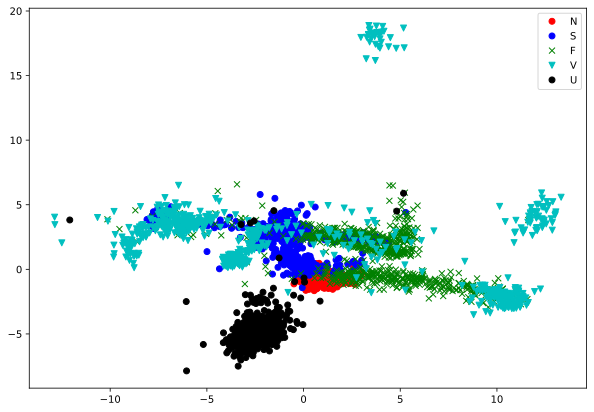

In [37]:
# Plot the first two PCA components of each class
plt.figure(figsize=(10,7))

plt.plot(feature0[:, 0], feature0[:, 1], 'or', label='N')
plt.plot(feature1[:, 0], feature1[:, 1], 'ob', label='S')
plt.plot(feature2[:, 0], feature2[:, 1], 'xg', label='F')
plt.plot(feature3[:, 0], feature3[:, 1], 'vc', label='V')
plt.plot(feature4[:, 0], feature4[:, 1], 'ok', label='U')

plt.legend()
plt.show()
